In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import time


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/My Drive/ass2/food'

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data path
training_path = f'{path}/training'
val_path = f'{path}/validation'
evaluation_path = f'{path}/evaluation'

In [ ]:
# set image paramater
batch_size = 32
image_size = 32

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
# transfer image
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing()
])

In [ ]:
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
val_dataset = datasets.ImageFolder(val_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ["Bread","Dairy product","Dessert","Egg","Fried food","Meat","Noodles-Pasta","Rice","Seafood","Soup","Vegetable-Fruit"]
num_classes = len(classes)

In [ ]:
# classes = ["Bread","Dairy product","Dessert","Egg","Fried food","Meat","Noodles-Pasta","Rice","Seafood","Soup","Vegetable-Fruit"]

# num_classes = len(classes)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

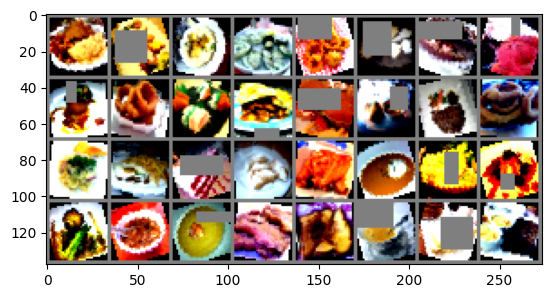

  Egg Dairy product  Soup Seafood Fried food Dairy product Dessert  Meat  Meat Fried food Seafood Dessert Bread  Soup  Meat Fried food Noodles-Pasta   Egg Dessert Dessert  Meat  Soup   Egg Dessert  Meat  Soup  Soup  Meat Bread  Soup Dairy product  Meat


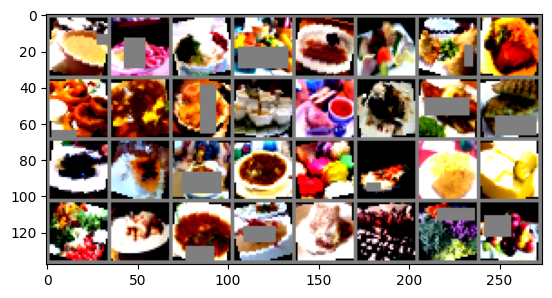

 Soup Seafood Dessert Vegetable-Fruit Fried food Seafood Fried food  Meat Fried food  Soup Bread  Soup Bread Dessert Fried food Bread Seafood Dessert Fried food  Soup Dessert Bread Fried food Dairy product Vegetable-Fruit Bread  Soup  Soup Dessert Dessert Vegetable-Fruit Vegetable-Fruit


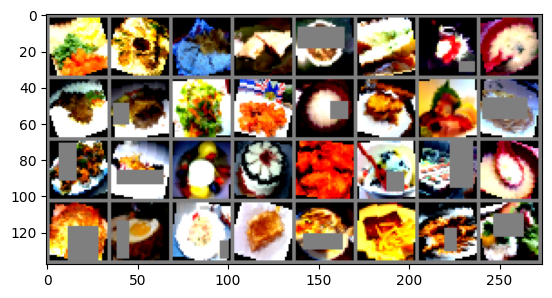

Vegetable-Fruit Seafood Bread Bread  Soup Bread Seafood  Soup  Meat  Meat Vegetable-Fruit  Meat  Soup Bread Seafood Noodles-Pasta Seafood Dessert Dessert Dessert  Meat Dessert Dessert  Soup Noodles-Pasta   Egg  Rice Bread   Egg  Meat Fried food   Egg


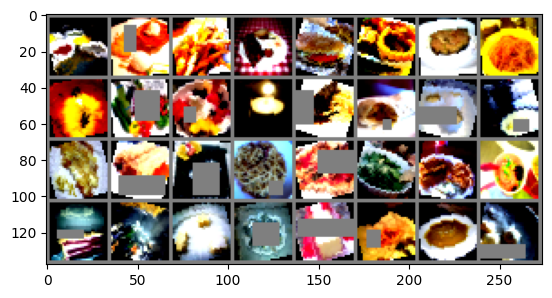

Seafood Dessert Fried food  Meat Bread Fried food  Meat Noodles-Pasta  Soup Vegetable-Fruit Dessert Dessert  Meat Bread   Egg  Soup   Egg Fried food Dessert Noodles-Pasta Bread Vegetable-Fruit Fried food Dessert Dessert Seafood Dairy product Seafood Dairy product Fried food  Soup  Soup


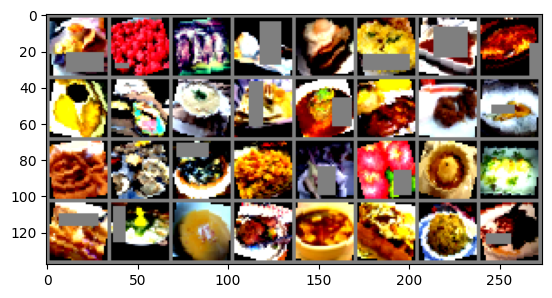

  Egg Vegetable-Fruit  Meat  Soup   Egg   Egg Dessert  Soup Fried food Seafood  Soup Bread  Meat  Meat  Meat Dessert Fried food Seafood Seafood  Rice Dessert Vegetable-Fruit  Soup   Egg  Soup Seafood  Soup  Meat  Soup Dessert  Rice  Meat


In [ ]:
images_set =[]
labels_set = []
# get some random training images
i=0
for images, labels in trainloader:
    # Your code to process each batch goes here
    # For example, you can print the shape of the batch
    images_set.append(images)
    labels_set.append(labels)
   # print("Batch shape:", image.shape)
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    i +=1
    if i == 5:
      break


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
print(None)
print(float('nan'))
None == float('nan')
print(m.isnan(float('nan')))


None
nan
True


In [ ]:
import math as m

In [ ]:
import math as m
def fit(model,trainloader,validloader,optimizer,criterion,num_epochs=5,callback=[]):
# set early stop parameter
    patience = 5
    best_val_loss = float('inf')
    counter = 0
    # dict to store training and validation accuracy
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        train_correct = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            #calculate loss

            running_loss += loss.item()
            #calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    # Calculate training loss

        train_loss = running_loss / len(trainloader)
        if m.isnan(train_loss):
          print("train loss is none,learning rate is too greate, change to smaller ")
          break
        # Calculate validation loss and accuracy
        train_accuracy = 100 * train_correct / total_train

        # Validation
        model.eval()  # Set the model in evaluation mode
        validation_loss = 0.0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            # Calculate validation loss and accuracy
        valid_loss = validation_loss / len(validloader)

        valid_accuracy = 100 * val_correct / total_val

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Train Accuracy:{train_accuracy:.2f}%, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")

        # Calculate training accuracy and validation accuracy
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_accuracy)
        history['valid_acc'].append(valid_accuracy)


        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            counter = 0
            # # save best model
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered.")
            break
    print("Training finished.")

    return model,history


In [ ]:
# def fit(model,trainloader,validloader,optimizer,criterion,num_epochs=5,callback=[]):

#   # dict to store training and validation accuracy
#   history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

#   # Training loop
#   for epoch in range(num_epochs):
#       running_loss = 0.0
#       train_correct = 0
#       total_train = 0

#       for inputs, labels in trainloader:
#           inputs, labels = inputs.to(device), labels.to(device)

#           # Zero the parameter gradients
#           optimizer.zero_grad()

#           # Forward pass
#           outputs = model(inputs)
#           loss = criterion(outputs, labels)

#           # Backpropagation and optimization
#           loss.backward()
#           optimizer.step()
#           #calculate loss
#           running_loss += loss.item()
#           #calculate accuracy
#           _, predicted = torch.max(outputs, 1)
#           total_train += labels.size(0)
#           train_correct += (predicted == labels).sum().item()

#       # Calculate training loss
#       train_loss = running_loss / len(trainloader)
#       # Calculate validation loss and accuracy
#       train_accuracy = 100 * train_correct / total_train
#   # train accuracy
#       # train_correct =0

#       # total_train = 0
#       # with torch.no_grad():
#       #     for inputs, labels in trainloader:
#       #         inputs, labels = inputs.to(device), labels.to(device)
#       #         outputs = model(inputs)
#       #         # loss = criterion(outputs, labels)
#       #         # train_loss += loss.item()

#               # _, predicted = torch.max(outputs, 1)
#               # total_train += labels.size(0)
#               # train_correct += (predicted == labels).sum().item()




#       # Validation
#       model.eval()  # Set the model in evaluation mode
#       validation_loss = 0.0
#       val_correct = 0
#       total_val = 0
#       with torch.no_grad():
#           for inputs, labels in validloader:
#               inputs, labels = inputs.to(device), labels.to(device)
#               outputs = model(inputs)
#               loss = criterion(outputs, labels)
#               validation_loss += loss.item()

#               _, predicted = torch.max(outputs, 1)
#               total_val += labels.size(0)
#               val_correct += (predicted == labels).sum().item()

#       # Calculate validation loss and accuracy
#       valid_loss = validation_loss / len(validloader)

#       valid_accuracy = 100 * val_correct / total_val

#       print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Train Accuracy:{train_accuracy:.2f}%, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")

#       # Calculate training accuracy and validation accuracy
#       # train_accuracy = 100 * train_correct / total_train
#       # valid_accuracy = 100 * val_correct / total_val

#       history['train_loss'].append(train_loss)
#       history['valid_loss'].append(valid_loss)
#       history['train_acc'].append(train_accuracy)
#       history['valid_acc'].append(valid_accuracy)

#   print("Training finished.")

#   return model,history


In [ ]:
### add metrix
def evaluate(model, testloader):
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            #print(correct_test)

    test_accuracy = correct_test / total_test
    print('Accuracy of the network on the test images: %d %%' % (100*test_accuracy))
    return test_accuracy, test_loss

In [ ]:
def plot_history(history,num_epochs):
    train_accuracy_history = history['train_acc']
    valid_accuracy_history = history['valid_acc']
    ### add loss
    #  history['train_loss'].append(train_loss)
    #     history['valid_loss'].append(valid_loss)
    # Plot the accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), history['train_loss'], 'b', label ='Training loss')
    plt.plot(range(1, num_epochs + 1), valid_accuracy_history, label='Validation Accuracy')
    plt.plot(range(1, num_epochs + 1), history['valid_loss'], 'g',label = 'validation loss')
    plt.legend(['Train Acc', 'Train Loss', 'Val Acc', 'Val Loss'])

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid()
    plt.show()


In [ ]:
# save history and sccuracy and export
import json
def save_hist(history,name):
  with open(name, 'w') as json_file:
      json.dump(history, json_file)
def export_hist(name):
  with open(name, 'r') as json_file:
    imported_data = json.load(json_file)
    return imported_data

In [ ]:
# import json
# def save_hist(history,name):
#   with open(name, 'w') as json_file:
#       json.dump(history, json_file)
# def export_hist(name):
#   with open(name, 'r') as json_file:
#     imported_data = json.load(json_file)
#     return imported_data

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)


In [ ]:
# # define a simple nerual network
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 53 * 53, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 11)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(x.size(0),-1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()
# net.to(device)
# print(net)

In [ ]:
import torch.optim as optim
# Define a Loss function and optimizer
# use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#model=net
num_epochs = 10
start_time = time.time()
model,history = fit(net,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()


Epoch 1/10, Training Loss: 2.3521, Train Accuracy:14.72%, Validation Loss: 2.3134, Validation Accuracy: 15.60%
Epoch 2/10, Training Loss: 2.2838, Train Accuracy:16.46%, Validation Loss: 2.2618, Validation Accuracy: 19.13%
Epoch 3/10, Training Loss: 2.2232, Train Accuracy:19.40%, Validation Loss: 2.2012, Validation Accuracy: 19.80%
Epoch 4/10, Training Loss: 2.1852, Train Accuracy:21.40%, Validation Loss: 2.1876, Validation Accuracy: 21.08%
Epoch 5/10, Training Loss: 2.1579, Train Accuracy:22.88%, Validation Loss: 2.1515, Validation Accuracy: 22.01%
Epoch 6/10, Training Loss: 2.1253, Train Accuracy:23.52%, Validation Loss: 2.1084, Validation Accuracy: 23.44%
Epoch 7/10, Training Loss: 2.0976, Train Accuracy:24.99%, Validation Loss: 2.0870, Validation Accuracy: 25.86%
Epoch 8/10, Training Loss: 2.0742, Train Accuracy:25.57%, Validation Loss: 2.0625, Validation Accuracy: 25.19%
Epoch 9/10, Training Loss: 2.0626, Train Accuracy:26.18%, Validation Loss: 2.0680, Validation Accuracy: 26.06%
E

In [ ]:
#save the net model and history
PATH = f'{path}/net.pth'
torch.save(net.state_dict(), PATH)
save_hist(history,f"{path}/net.json")


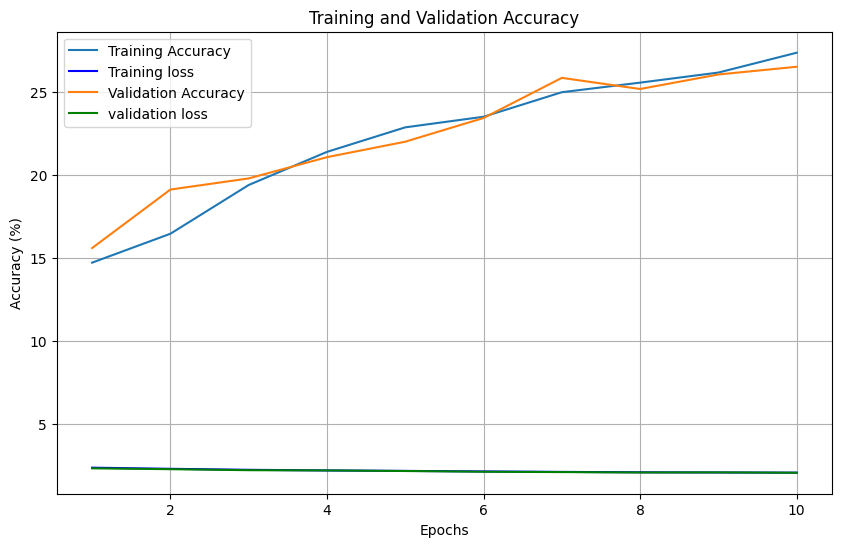

In [ ]:
plot_history(history,num_epochs)

In [ ]:
base_line={}
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])
base_line['basic cnn'] = [val_acc,spend_time]
print(base_line)

#test_acc,test_loss = evaluate(model,testloader)

{'basic cnn': [26.53061224489796, 2475.005430459976]}


VGG

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
# Modify the last layer for your specific classification task
num_classes = len(classes)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.2MB/s]


In [ ]:
#model =vgg16
num_epochs = 10
# keep starting time and ending time
start_time = time.time()
model,history = fit(vgg16,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.1079, Train Accuracy:26.82%, Validation Loss: 1.8701, Validation Accuracy: 35.86%
Epoch 2/10, Training Loss: 1.7386, Train Accuracy:40.11%, Validation Loss: 1.7170, Validation Accuracy: 39.62%
Epoch 3/10, Training Loss: 1.5928, Train Accuracy:45.62%, Validation Loss: 1.5786, Validation Accuracy: 45.57%
Epoch 4/10, Training Loss: 1.4819, Train Accuracy:49.18%, Validation Loss: 1.5210, Validation Accuracy: 46.41%
Epoch 5/10, Training Loss: 1.4166, Train Accuracy:51.05%, Validation Loss: 1.4564, Validation Accuracy: 50.90%
Epoch 6/10, Training Loss: 1.3663, Train Accuracy:52.74%, Validation Loss: 1.4442, Validation Accuracy: 51.20%
Epoch 7/10, Training Loss: 1.3085, Train Accuracy:55.41%, Validation Loss: 1.3704, Validation Accuracy: 53.21%
Epoch 8/10, Training Loss: 1.2686, Train Accuracy:56.43%, Validation Loss: 1.3591, Validation Accuracy: 53.47%
Epoch 9/10, Training Loss: 1.2403, Train Accuracy:57.28%, Validation Loss: 1.3494, Validation Accuracy: 55.16%
E

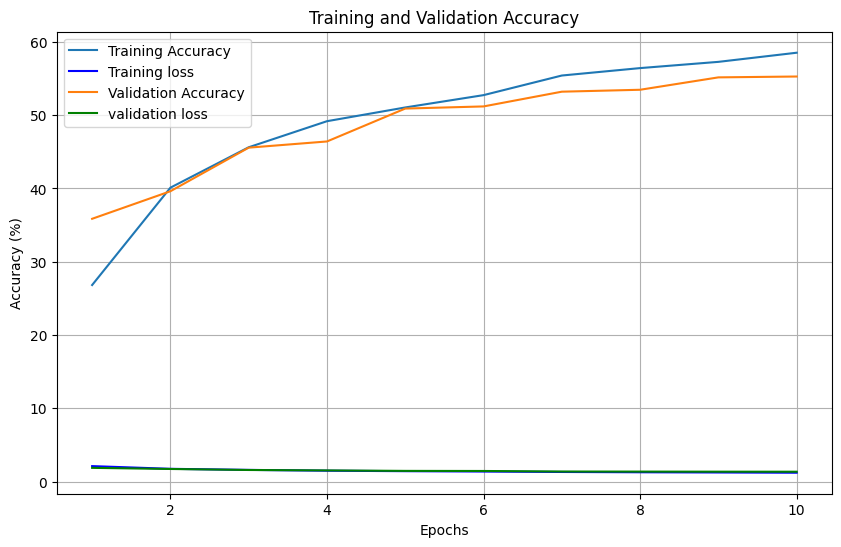

In [ ]:
plot_history(history,num_epochs)

In [ ]:
PATH = f'{path}/vgg16.pth'
torch.save(vgg16.state_dict(), PATH)
save_hist(history,f"{path}/vgg16.json")



In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])

base_line['vgg16'] = [val_acc,spend_time]




In [ ]:
vgg16 = torchvision.models.vgg16()
# Modify the last layer for your specific classification task
num_classes = len(classes)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

In [ ]:
#model =vgg16
num_epochs = 10
# keep starting time and ending time
start_time = time.time()
model,history = fit(vgg16,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.3548, Train Accuracy:14.59%, Validation Loss: 2.3119, Validation Accuracy: 14.58%
Epoch 2/10, Training Loss: 2.2936, Train Accuracy:15.25%, Validation Loss: 2.2906, Validation Accuracy: 15.86%
Epoch 3/10, Training Loss: 2.2847, Train Accuracy:15.80%, Validation Loss: 2.2814, Validation Accuracy: 14.58%
Epoch 4/10, Training Loss: 2.2785, Train Accuracy:16.69%, Validation Loss: 2.2788, Validation Accuracy: 14.58%
Epoch 5/10, Training Loss: 2.2708, Train Accuracy:16.76%, Validation Loss: 2.2674, Validation Accuracy: 16.27%
Epoch 6/10, Training Loss: 2.2648, Train Accuracy:18.32%, Validation Loss: 2.2634, Validation Accuracy: 17.81%
Epoch 7/10, Training Loss: 2.2567, Train Accuracy:19.21%, Validation Loss: 2.2538, Validation Accuracy: 19.65%
Epoch 8/10, Training Loss: 2.2461, Train Accuracy:19.72%, Validation Loss: 2.2348, Validation Accuracy: 19.24%
Epoch 9/10, Training Loss: 2.2318, Train Accuracy:20.21%, Validation Loss: 2.2248, Validation Accuracy: 19.62%
E

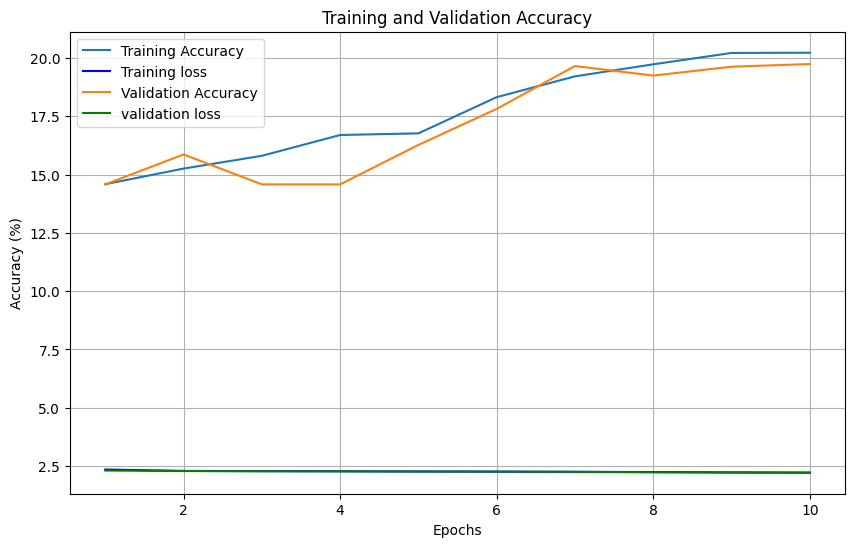

In [ ]:
plot_history(history,num_epochs)

In [ ]:
PATH = f'{path}/vgg16_default.pth'
torch.save(vgg16.state_dict(), PATH)
save_hist(history,f"{path}/vgg16_default.json")



In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])

base_line['vgg16_default'] = [val_acc,spend_time]




In [ ]:
base_line

{'basic cnn': [26.53061224489796, 2475.005430459976],
 'vgg16': [55.27696793002915, 791.6775026321411],
 'resnet50': [27.871720116618075, 767.9913880825043],
 'vgg16_64': [22.39067055393586, 817.2729835510254],
 'resnet50_64': [32.6530612244898, 834.4013390541077],
 'vgg16_128_32': [19.620991253644316, 757.8417794704437],
 'resnet50_128_32': [22.332361516034986, 728.4337406158447],
 'vgg16_32_224': [29.737609329446062, 1840.2045896053314],
 'resnet50_32_224': [37.90087463556851, 4098.392594337463],
 'vgg16_32_224_pretrain': [84.46064139941691, 1332.7040567398071],
 'resnet50_32_224_pretrain': [85.56851311953353, 1357.7137651443481],
 'vgg16_default': [19.737609329446062, 737.3647184371948]}

In [ ]:
#export vgg16 model trained
model_vgg = torchvision.models.vgg16(pretrained=True)
model_vgg.classifier[6] = nn.Linear(4096, num_classes)
model_vgg.to(device)
PATH = f'{path}/vgg16.pth'
model_vgg.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model_vgg.to(device)

In [ ]:
# history1 = export_hist(f"{path}/vgg16.json")
# plot_history(history1,num_epochs)

Rsenet

In [ ]:
# Define your ResNet model
resnet50 = torchvision.models.resnet50()
# Modify the output layer to match the number of classes in your dataset
num_classes = len(classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

The model builder above accepts the following values as the weights parameter. ResNet50_Weights.DEFAULT is equivalent to ResNet50_Weights.IMAGENET1K_V2. You can also use strings, e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [ ]:
# keep spending  time start time and end time
start_time = time.time()
num_epochs = 10
model,history = fit(resnet50,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.6742, Train Accuracy:15.18%, Validation Loss: 3.3961, Validation Accuracy: 18.10%
Epoch 2/10, Training Loss: 2.2785, Train Accuracy:19.01%, Validation Loss: 2.1419, Validation Accuracy: 22.30%
Epoch 3/10, Training Loss: 2.1745, Train Accuracy:22.26%, Validation Loss: 2.1828, Validation Accuracy: 20.12%
Epoch 4/10, Training Loss: 2.1176, Train Accuracy:23.76%, Validation Loss: 2.0877, Validation Accuracy: 24.34%
Epoch 5/10, Training Loss: 2.0773, Train Accuracy:25.27%, Validation Loss: 2.0525, Validation Accuracy: 26.01%
Epoch 6/10, Training Loss: 2.0549, Train Accuracy:26.12%, Validation Loss: 2.0703, Validation Accuracy: 26.47%
Epoch 7/10, Training Loss: 2.0234, Train Accuracy:27.81%, Validation Loss: 2.0200, Validation Accuracy: 27.78%
Epoch 8/10, Training Loss: 2.0027, Train Accuracy:29.08%, Validation Loss: 2.0045, Validation Accuracy: 27.87%
Epoch 9/10, Training Loss: 1.9733, Train Accuracy:29.89%, Validation Loss: 2.0208, Validation Accuracy: 26.65%
E

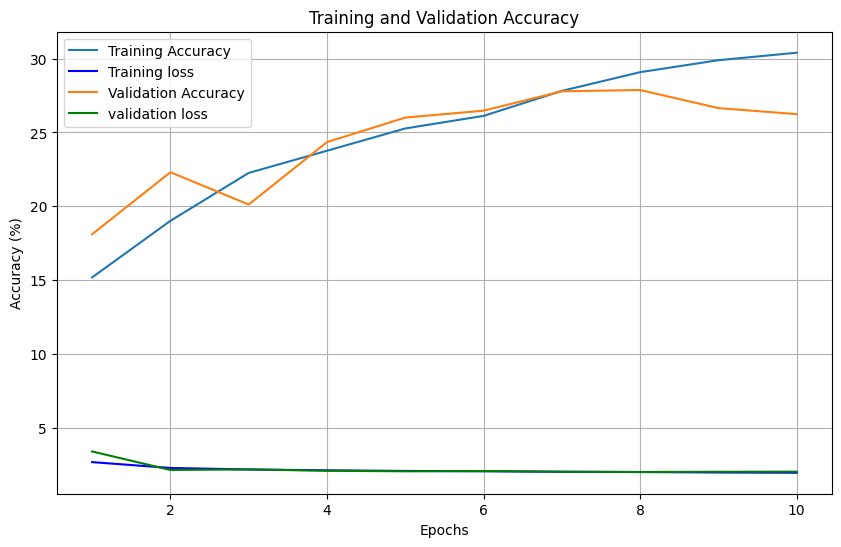

In [ ]:
plot_history(history,num_epochs)


In [ ]:
PATH = f'{path}/resnet50.pth'
torch.save(resnet50.state_dict(), PATH)
save_hist(history,f"{path}/resnet50.json")

In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])
base_line['resnet50']=[val_acc,spend_time]


In [ ]:
# load trained resnet50 model
model_resnet50 = torchvision.models.resnet50()
model_resnet50.fc = nn.Linear(model.fc.in_features, num_classes)
PATH = f'{path}/resnet50.pth'
model_resnet50.load_state_dict(torch.load(PATH))


In [ ]:
history1 = export_hist(f"{path}/resnet50.json")
plot_history(history1,num_epochs)

NameError: ignored

In [ ]:
# Define hyperparameter search space
# test other learning rate
learning_rates = [0.01, 0.1]
batch_sizes = [32, 64, 128]
#dropout_rates = [0.0, 0.2, 0.5]

num_epochs = 10
best_accuracy = 0
best_model = None
best_history =[]
best_result = {}
model_para =[]
for learning_rate in learning_rates:
# Define a loss function, optimizer, and evaluation metric
  model = torchvision.models.vgg16()
  # Modify the last layer for your specific classification task
  model.classifier[6] = nn.Linear(4096, num_classes)
  model.to(device)
  criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Adjust learning rate and optimizer

  model,hist = fit(model,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
  PATH = f'{path}/cnn_lr_{learning_rate}.pth'
  torch.save(model.state_dict(), PATH)
  save_hist(history,f"{path}/cnn_lr_{learning_rate}.json")

  # return the maximum accuracy of the validation set
  acc = max(hist['valid_acc'])
  model_para.append({
    'model': model,
    'valacc':acc,
    'learningrate': learning_rate,
    'history':history
  })
  if acc > best_accuracy:
          best_accuracy = acc
          best_model = model
          best_history = history
          best_result = {
              'model': model,
              'learning_rate': learning_rate,
              'accuracy' : best_accuracy,
              'history' : history

                }

print("Best Hyperparameters:")
print(best_result)
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
#print(model_para)

Epoch 1/10, Training Loss: 2.2786, Train Accuracy:16.65%, Validation Loss: 2.2610, Validation Accuracy: 18.51%
Epoch 2/10, Training Loss: 2.2653, Train Accuracy:17.75%, Validation Loss: 2.2319, Validation Accuracy: 20.93%
Epoch 3/10, Training Loss: 2.2064, Train Accuracy:20.67%, Validation Loss: 2.1643, Validation Accuracy: 20.52%
Epoch 4/10, Training Loss: 2.1772, Train Accuracy:22.13%, Validation Loss: 2.1403, Validation Accuracy: 21.60%
Epoch 5/10, Training Loss: 2.1172, Train Accuracy:24.83%, Validation Loss: 2.0722, Validation Accuracy: 26.38%
Epoch 6/10, Training Loss: 2.0738, Train Accuracy:26.12%, Validation Loss: 2.0111, Validation Accuracy: 29.10%
Epoch 7/10, Training Loss: 2.0539, Train Accuracy:26.63%, Validation Loss: 1.9799, Validation Accuracy: 28.51%
Epoch 8/10, Training Loss: 2.0146, Train Accuracy:28.04%, Validation Loss: 2.0419, Validation Accuracy: 29.15%
Epoch 9/10, Training Loss: 1.9768, Train Accuracy:30.38%, Validation Loss: 1.9746, Validation Accuracy: 29.94%
E

In [ ]:
#evaluate best model on test set
learning_rate = best_result['learning_rate']
model = best_result['model']
correct = 0
total = 0
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Adjust learning rate and optimizer
test_acc,test_loss = evaluate(model,testloader)


fit VGG16 and ResNet50 with image size 64


In [ ]:

# set image paramater
batch_size = 32
image_size = 64

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# transfer image
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing()
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
val_dataset = datasets.ImageFolder(val_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# classes = ["Bread","Dairy product","Dessert","Egg","Fried food","Meat","Noodles-Pasta","Rice","Seafood","Soup","Vegetable-Fruit"]
# num_classes = len(classes)

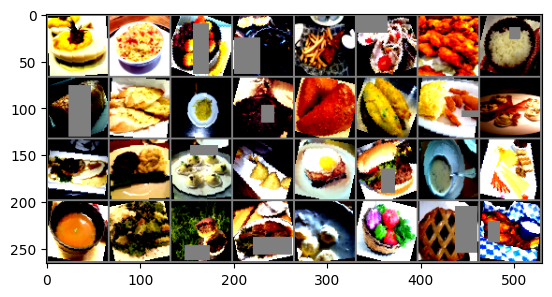

  Egg  Rice Vegetable-Fruit Seafood Fried food Seafood  Meat  Rice Bread Bread Noodles-Pasta  Meat Bread   Egg   Egg   Egg  Meat  Meat   Egg Fried food   Egg Bread  Soup Dairy product  Soup Vegetable-Fruit Dessert  Meat  Soup Vegetable-Fruit Dessert  Meat


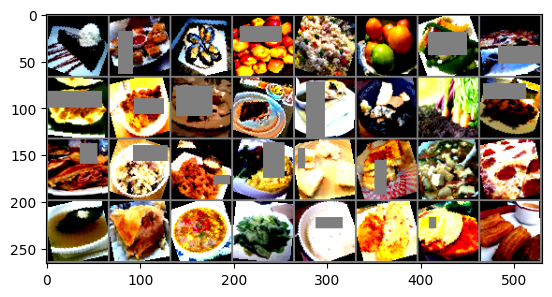

Dessert Bread Seafood Vegetable-Fruit  Rice Vegetable-Fruit Vegetable-Fruit Bread   Egg  Meat Dessert  Meat Bread Dairy product Vegetable-Fruit  Meat Bread  Rice Fried food   Egg Dairy product Bread  Soup Bread  Soup Dessert  Soup Vegetable-Fruit  Soup   Egg   Egg Fried food


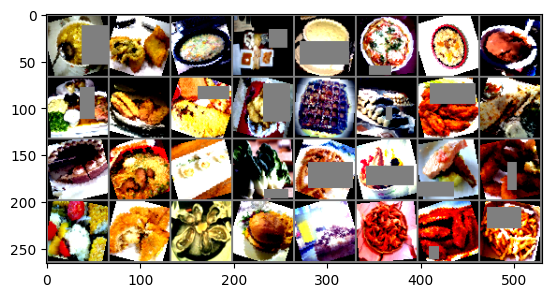

 Soup Fried food  Soup Dairy product  Soup Bread  Rice Dessert  Meat Bread   Egg Fried food Dessert Dessert  Meat Bread Dessert Noodles-Pasta   Egg Vegetable-Fruit Dessert Dessert Seafood Fried food Vegetable-Fruit Fried food Seafood Bread Dessert  Meat  Meat Fried food


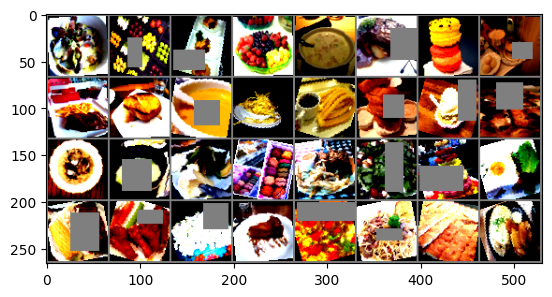

 Soup Vegetable-Fruit   Egg Vegetable-Fruit  Soup  Meat Dessert Dessert  Meat Bread  Soup Fried food Fried food Fried food Dessert Bread  Soup  Soup Dairy product Dessert  Meat Vegetable-Fruit Dessert   Egg  Meat  Meat Dairy product Dessert Bread Noodles-Pasta Bread   Egg


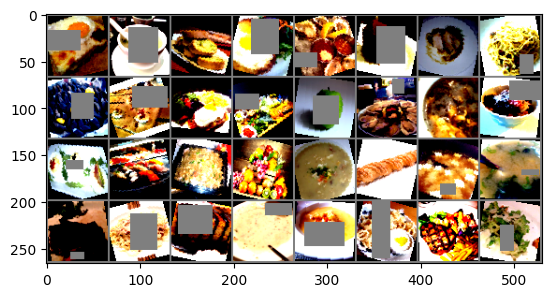

  Egg  Soup Bread   Egg Seafood Dessert  Meat Noodles-Pasta Seafood   Egg   Egg Vegetable-Fruit Vegetable-Fruit Seafood  Soup Dessert   Egg Seafood  Rice Vegetable-Fruit  Soup Fried food  Soup  Soup  Meat Noodles-Pasta Dessert  Soup  Soup Fried food  Meat Vegetable-Fruit


In [ ]:
images_set =[]
labels_set = []
# get some random training images
i=0
for images, labels in trainloader:
    # Your code to process each batch goes here
    # For example, you can print the shape of the batch
    images_set.append(images)
    labels_set.append(labels)
   # print("Batch shape:", image.shape)
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    i +=1
    if i == 5:
      break


In [ ]:
vgg16 = torchvision.models.vgg16()
# Modify the last layer for your specific classification task
num_classes = len(classes)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

In [ ]:
#model =vgg16
num_epochs = 10
# keep starting time and ending time
start_time = time.time()
model,history = fit(vgg16,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.3253, Train Accuracy:14.75%, Validation Loss: 2.2913, Validation Accuracy: 14.58%
Epoch 2/10, Training Loss: 2.2815, Train Accuracy:15.82%, Validation Loss: 2.2736, Validation Accuracy: 17.29%
Epoch 3/10, Training Loss: 2.2668, Train Accuracy:18.31%, Validation Loss: 2.2608, Validation Accuracy: 19.18%
Epoch 4/10, Training Loss: 2.2477, Train Accuracy:20.34%, Validation Loss: 2.2517, Validation Accuracy: 17.76%
Epoch 5/10, Training Loss: 2.2310, Train Accuracy:20.45%, Validation Loss: 2.2132, Validation Accuracy: 20.20%
Epoch 6/10, Training Loss: 2.2153, Train Accuracy:20.65%, Validation Loss: 2.2040, Validation Accuracy: 19.62%
Epoch 7/10, Training Loss: 2.1981, Train Accuracy:21.31%, Validation Loss: 2.2025, Validation Accuracy: 20.67%
Epoch 8/10, Training Loss: 2.1879, Train Accuracy:22.40%, Validation Loss: 2.1774, Validation Accuracy: 21.43%
Epoch 9/10, Training Loss: 2.1664, Train Accuracy:22.44%, Validation Loss: 2.1516, Validation Accuracy: 22.39%
E

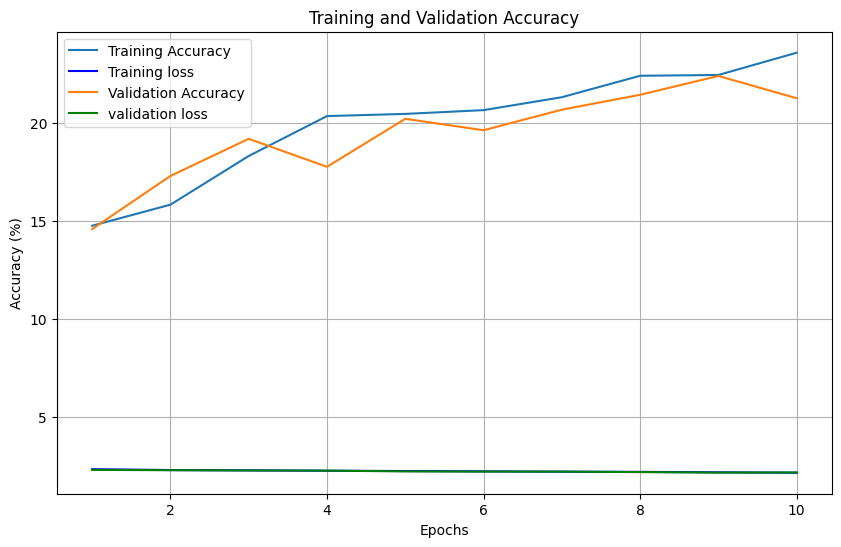

In [ ]:
plot_history(history,num_epochs)

In [ ]:
PATH = f'{path}/vgg16_224.pth'
torch.save(vgg16.state_dict(), PATH)
save_hist(history,f"{path}/vgg16_224.json")



In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])

base_line['vgg16_224'] = [val_acc,spend_time]




In [ ]:
# #export vgg16 model trained
# model_vgg = torchvision.models.vgg16(pretrained=True)
# model_vgg.classifier[6] = nn.Linear(4096, num_classes)
# model_vgg.to(device)
# PATH = f'{path}/vgg16.pth'
# model_vgg.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
# model_vgg.to(device)

In [ ]:
# history1 = export_hist(f"{path}/vgg16.json")
# plot_history(history1,num_epochs)

Rsenet

In [ ]:
# Define your ResNet model
resnet50 = torchvision.models.resnet50()
# Modify the output layer to match the number of classes in your dataset
num_classes = len(classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

The model builder above accepts the following values as the weights parameter. ResNet50_Weights.DEFAULT is equivalent to ResNet50_Weights.IMAGENET1K_V2. You can also use strings, e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [ ]:
# keep spending  time start time and end time
start_time = time.time()
num_epochs = 10
model,history = fit(resnet50,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.4775, Train Accuracy:14.84%, Validation Loss: 2.4906, Validation Accuracy: 13.44%
Epoch 2/10, Training Loss: 2.3163, Train Accuracy:17.68%, Validation Loss: 2.1749, Validation Accuracy: 20.35%
Epoch 3/10, Training Loss: 2.1899, Train Accuracy:21.66%, Validation Loss: 2.1473, Validation Accuracy: 21.95%
Epoch 4/10, Training Loss: 2.1461, Train Accuracy:23.31%, Validation Loss: 2.0961, Validation Accuracy: 24.66%
Epoch 5/10, Training Loss: 2.0935, Train Accuracy:25.20%, Validation Loss: 2.0360, Validation Accuracy: 26.68%
Epoch 6/10, Training Loss: 2.0549, Train Accuracy:27.32%, Validation Loss: 2.0568, Validation Accuracy: 26.73%
Epoch 7/10, Training Loss: 2.0076, Train Accuracy:28.54%, Validation Loss: 1.9972, Validation Accuracy: 29.80%
Epoch 8/10, Training Loss: 1.9645, Train Accuracy:30.52%, Validation Loss: 1.9280, Validation Accuracy: 32.65%
Epoch 9/10, Training Loss: 1.9316, Train Accuracy:32.27%, Validation Loss: 1.9586, Validation Accuracy: 29.33%
E

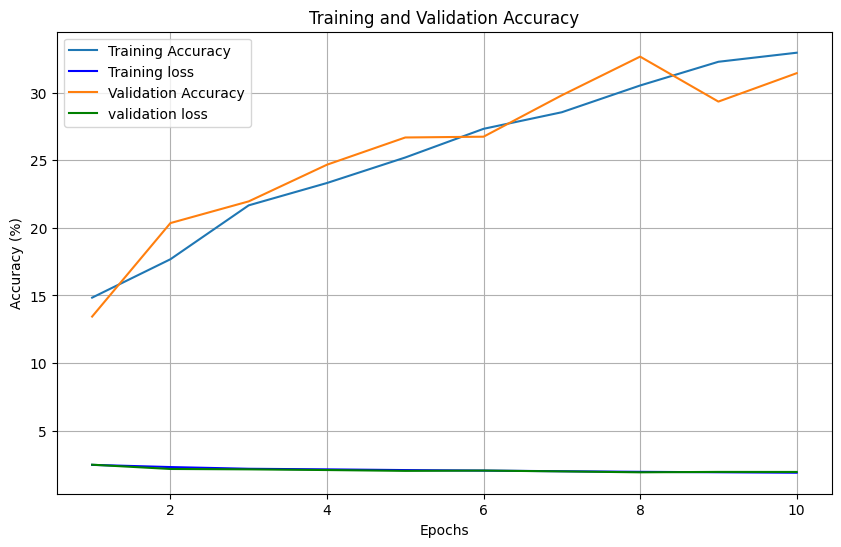

In [ ]:
plot_history(history,num_epochs)


In [ ]:
PATH = f'{path}/resnet50_64.pth'
torch.save(resnet50.state_dict(), PATH)
save_hist(history,f"{path}/resnet50_64.json")

In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])
base_line['resnet50_224']=[val_acc,spend_time]
print(base_line)

same size with first train change the batch size to 128
see the runnung time

In [ ]:

# set image paramater
batch_size = 128
image_size = 32

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# transfer image
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing()
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
val_dataset = datasets.ImageFolder(val_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# classes = ["Bread","Dairy product","Dessert","Egg","Fried food","Meat","Noodles-Pasta","Rice","Seafood","Soup","Vegetable-Fruit"]
# num_classes = len(classes)

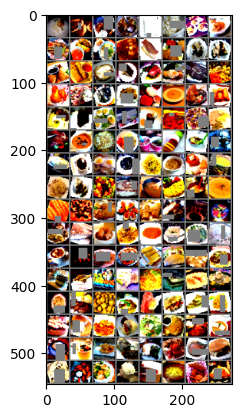

Dessert  Soup Fried food  Soup Dairy product  Rice Fried food   Egg  Meat Fried food Noodles-Pasta  Soup Dessert Fried food Dessert  Meat Fried food Fried food   Egg Dessert  Meat   Egg  Meat Vegetable-Fruit Fried food Bread Seafood Noodles-Pasta Dessert  Soup Fried food Fried food   Egg Dessert   Egg Dessert Dessert  Meat Bread  Meat  Meat  Soup Bread  Rice Dessert Dessert Dessert Dessert   Egg  Soup   Egg Seafood Noodles-Pasta  Soup Dessert  Soup Noodles-Pasta  Meat Vegetable-Fruit Bread  Soup   Egg  Soup  Soup Seafood Bread  Meat Seafood Bread Seafood  Meat  Meat   Egg Bread Fried food Noodles-Pasta  Soup  Soup Vegetable-Fruit  Soup  Soup Vegetable-Fruit Bread Bread Bread Bread  Soup Noodles-Pasta Dessert Fried food Vegetable-Fruit Bread Noodles-Pasta Dessert Dessert Seafood Noodles-Pasta  Meat Vegetable-Fruit  Meat Dessert   Egg Dessert  Rice Dessert Bread Noodles-Pasta   Egg Vegetable-Fruit  Meat  Meat  Soup Dessert Dessert Fried food Bread   Egg Bread  Meat Bread  Rice  Meat Vege

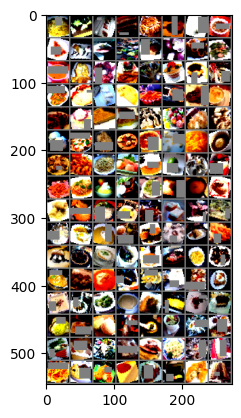

Noodles-Pasta Dairy product Seafood Dessert Fried food  Meat Dairy product  Soup Bread Dessert Dessert Vegetable-Fruit  Meat Vegetable-Fruit Fried food Vegetable-Fruit  Soup Bread  Meat Fried food Seafood Dessert Dessert Dessert Fried food   Egg Dairy product   Egg Fried food Fried food  Meat  Soup  Meat Dessert Bread Bread Dessert Vegetable-Fruit Bread Fried food Dessert Bread Noodles-Pasta   Egg  Soup Dairy product  Soup  Soup Seafood Fried food Noodles-Pasta Seafood   Egg Vegetable-Fruit Seafood Dessert  Meat Noodles-Pasta Dessert  Meat Vegetable-Fruit Dessert  Soup Dessert Fried food Bread  Meat Dessert Fried food Dessert  Meat Bread Seafood   Egg  Soup Seafood Fried food Seafood Bread Fried food Dessert Seafood  Soup  Soup Bread Seafood   Egg Seafood  Soup  Meat  Soup Seafood Fried food  Soup   Egg   Egg  Soup Dessert Vegetable-Fruit  Soup Fried food   Egg Dessert Dessert Bread Fried food Dessert  Meat  Soup Dessert Seafood   Egg Vegetable-Fruit Seafood Seafood Dairy product  Meat

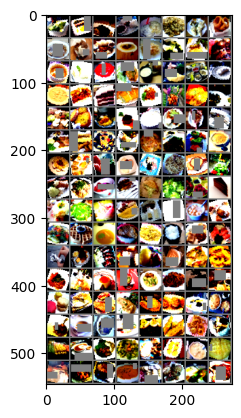

Vegetable-Fruit Dessert  Meat Bread Dessert  Rice Bread Fried food  Soup Dessert Bread Noodles-Pasta Noodles-Pasta  Soup   Egg  Meat  Soup Dairy product Dessert Noodles-Pasta  Soup   Egg Seafood Dessert  Soup  Meat Dessert Bread Noodles-Pasta Vegetable-Fruit Bread Seafood Dairy product Bread Noodles-Pasta  Meat  Soup  Meat Bread Seafood  Meat Bread Seafood Bread Bread  Meat Vegetable-Fruit  Soup   Egg Seafood Vegetable-Fruit Dessert Dessert Noodles-Pasta  Soup Vegetable-Fruit Dessert   Egg Dessert Dessert Bread Vegetable-Fruit Vegetable-Fruit Dessert   Egg Vegetable-Fruit Dessert   Egg Dairy product Dairy product  Soup Fried food  Soup Dessert  Soup Dessert Noodles-Pasta  Rice   Egg Seafood Dessert  Meat  Meat Dairy product Vegetable-Fruit  Soup Bread Fried food  Meat Dairy product Dessert  Soup   Egg Noodles-Pasta  Meat  Meat Dessert Bread   Egg   Egg Bread   Egg Dessert Noodles-Pasta Dessert  Soup  Soup Dairy product   Egg Bread Fried food Dessert Dessert  Soup  Meat Vegetable-Fruit 

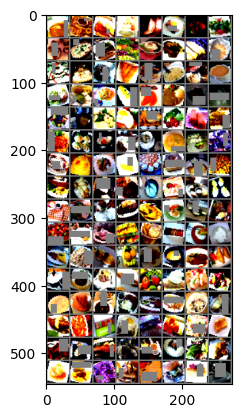

 Soup Fried food Bread Dairy product Dessert   Egg Vegetable-Fruit Vegetable-Fruit Seafood Bread Seafood Vegetable-Fruit Dessert  Meat Fried food  Soup Dessert Dairy product Dessert Fried food Fried food Noodles-Pasta Dessert  Soup   Egg Bread Noodles-Pasta   Egg Seafood  Meat  Meat  Soup Vegetable-Fruit  Soup Seafood   Egg Bread Vegetable-Fruit Fried food  Meat  Meat   Egg Seafood   Egg  Soup  Soup   Egg Seafood Seafood   Egg  Meat Dairy product Dessert Dessert Fried food Vegetable-Fruit  Meat Bread Dairy product  Meat  Soup Seafood Dairy product   Egg Dessert Vegetable-Fruit Dessert  Meat   Egg   Egg Dairy product  Meat Vegetable-Fruit  Meat  Meat Vegetable-Fruit Fried food Dessert Dessert  Rice   Egg  Rice   Egg Vegetable-Fruit Fried food  Soup  Meat Fried food Dessert  Meat  Meat Bread Vegetable-Fruit Dessert Seafood Vegetable-Fruit  Soup Fried food  Soup  Meat  Meat   Egg  Rice   Egg Fried food  Soup Dessert   Egg Bread Vegetable-Fruit  Rice Bread  Meat   Egg  Meat Seafood  Soup D

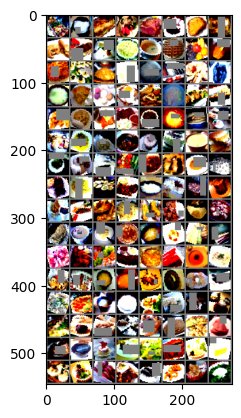

Vegetable-Fruit  Rice Bread Seafood  Meat Dessert Bread Dessert Fried food Dessert  Meat Noodles-Pasta  Soup Dessert Vegetable-Fruit  Soup Dessert   Egg  Rice Dairy product  Soup Dessert Bread Seafood  Soup Dessert Dessert   Egg Fried food  Soup Fried food Dessert Fried food  Rice  Meat  Meat  Soup  Soup Dessert   Egg   Egg Noodles-Pasta Bread Noodles-Pasta  Soup Dessert  Soup Bread  Meat Dairy product Dessert Vegetable-Fruit  Soup  Soup  Soup Seafood  Meat Noodles-Pasta Seafood  Meat  Rice Dairy product Bread Dessert Fried food Bread  Meat Noodles-Pasta Seafood Dessert  Rice Bread Bread  Soup  Soup  Soup  Soup Dessert Bread Dessert  Meat  Meat Vegetable-Fruit  Meat Bread Dessert  Soup  Soup Fried food Dessert  Soup  Soup Dessert  Soup Bread  Meat  Rice Bread  Soup  Soup Fried food  Rice Dairy product  Soup  Meat  Meat Bread Dessert  Meat  Soup   Egg Fried food Fried food Dessert Dessert Dessert Vegetable-Fruit  Meat Dairy product Dairy product   Egg Dessert Dessert   Egg Dessert Fried

In [ ]:
images_set =[]
labels_set = []
# get some random training images
i=0
for images, labels in trainloader:
    # Your code to process each batch goes here
    # For example, you can print the shape of the batch
    images_set.append(images)
    labels_set.append(labels)
   # print("Batch shape:", image.shape)
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    i +=1
    if i == 5:
      break


In [ ]:
vgg16 = torchvision.models.vgg16()
# Modify the last layer for your specific classification task
num_classes = len(classes)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

In [ ]:
#model =vgg16
num_epochs = 10
# keep starting time and ending time
start_time = time.time()
model,history = fit(vgg16,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.3924, Train Accuracy:10.87%, Validation Loss: 2.3831, Validation Accuracy: 15.25%
Epoch 2/10, Training Loss: 2.3710, Train Accuracy:15.88%, Validation Loss: 2.3592, Validation Accuracy: 14.66%
Epoch 3/10, Training Loss: 2.3429, Train Accuracy:15.36%, Validation Loss: 2.3269, Validation Accuracy: 14.87%
Epoch 4/10, Training Loss: 2.3038, Train Accuracy:16.16%, Validation Loss: 2.2940, Validation Accuracy: 14.61%
Epoch 5/10, Training Loss: 2.2852, Train Accuracy:15.79%, Validation Loss: 2.2841, Validation Accuracy: 19.62%
Epoch 6/10, Training Loss: 2.2780, Train Accuracy:17.84%, Validation Loss: 2.2797, Validation Accuracy: 17.61%
Epoch 7/10, Training Loss: 2.2757, Train Accuracy:17.53%, Validation Loss: 2.2779, Validation Accuracy: 15.34%
Epoch 8/10, Training Loss: 2.2763, Train Accuracy:17.67%, Validation Loss: 2.2745, Validation Accuracy: 18.08%
Epoch 9/10, Training Loss: 2.2744, Train Accuracy:17.66%, Validation Loss: 2.2744, Validation Accuracy: 16.88%
E

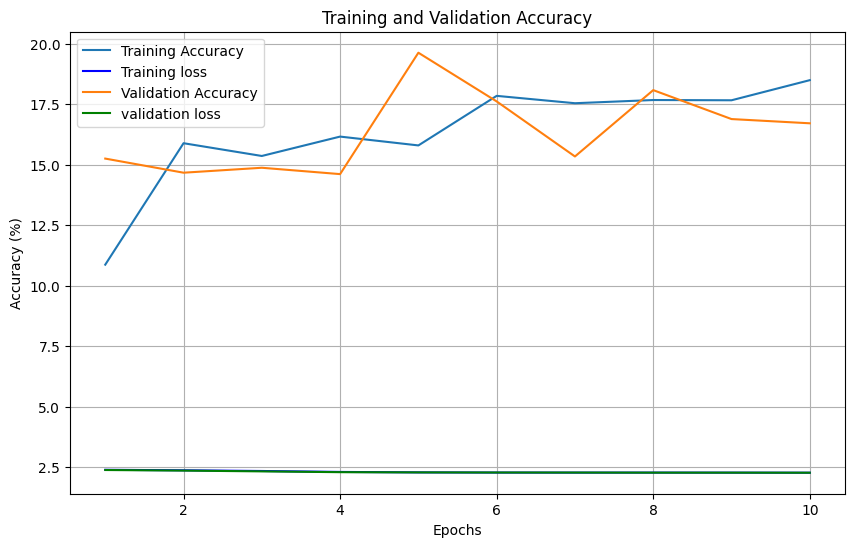

In [ ]:
plot_history(history,num_epochs)

In [ ]:
PATH = f'{path}/vgg16_128_32.pth'
torch.save(vgg16.state_dict(), PATH)
save_hist(history,f"{path}/vgg16_128_32.json")



In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])

base_line['vgg16_128_32'] = [val_acc,spend_time]




In [ ]:
# #export vgg16 model trained
# model_vgg = torchvision.models.vgg16(pretrained=True)
# model_vgg.classifier[6] = nn.Linear(4096, num_classes)
# model_vgg.to(device)
# PATH = f'{path}/vgg16.pth'
# model_vgg.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
# model_vgg.to(device)

In [ ]:
# history1 = export_hist(f"{path}/vgg16.json")
# plot_history(history1,num_epochs)

Rsenet

In [ ]:
# Define your ResNet model
resnet50 = torchvision.models.resnet50()
# Modify the output layer to match the number of classes in your dataset
num_classes = len(classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

The model builder above accepts the following values as the weights parameter. ResNet50_Weights.DEFAULT is equivalent to ResNet50_Weights.IMAGENET1K_V2. You can also use strings, e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [ ]:
# keep spending  time start time and end time
start_time = time.time()
num_epochs = 10
model,history = fit(resnet50,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.4580, Train Accuracy:13.80%, Validation Loss: 2.5440, Validation Accuracy: 15.69%
Epoch 2/10, Training Loss: 2.4344, Train Accuracy:15.54%, Validation Loss: 2.3507, Validation Accuracy: 16.97%
Epoch 3/10, Training Loss: 2.3041, Train Accuracy:17.07%, Validation Loss: 2.3607, Validation Accuracy: 16.06%
Epoch 4/10, Training Loss: 2.2765, Train Accuracy:17.10%, Validation Loss: 2.2563, Validation Accuracy: 19.62%
Epoch 5/10, Training Loss: 2.2367, Train Accuracy:18.61%, Validation Loss: 2.2506, Validation Accuracy: 17.61%
Epoch 6/10, Training Loss: 2.2046, Train Accuracy:20.57%, Validation Loss: 2.2240, Validation Accuracy: 18.95%
Epoch 7/10, Training Loss: 2.1861, Train Accuracy:20.62%, Validation Loss: 2.1996, Validation Accuracy: 20.96%
Epoch 8/10, Training Loss: 2.1812, Train Accuracy:21.63%, Validation Loss: 2.1420, Validation Accuracy: 22.10%
Epoch 9/10, Training Loss: 2.1653, Train Accuracy:22.56%, Validation Loss: 2.1606, Validation Accuracy: 21.84%
E

In [ ]:
PATH = f'{path}/resnet50_128_32.pth'
torch.save(resnet50.state_dict(), PATH)
save_hist(history,f"{path}/resnet50_128_32.json")

In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])
base_line['resnet50_128_32']=[val_acc,spend_time]

Batch size = 32 and image size = 224

In [ ]:

# set image paramater
batch_size = 32
image_size = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# transfer image
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing()
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
val_dataset = datasets.ImageFolder(val_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# classes = ["Bread","Dairy product","Dessert","Egg","Fried food","Meat","Noodles-Pasta","Rice","Seafood","Soup","Vegetable-Fruit"]
# num_classes = len(classes)

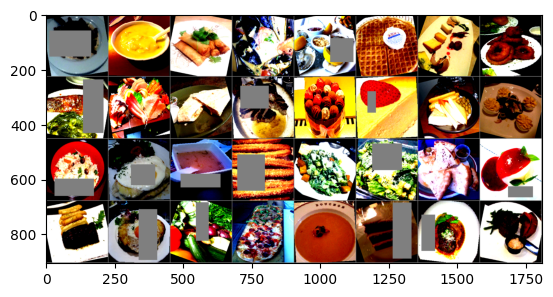

 Meat  Soup Fried food Seafood Seafood Dessert Dairy product Fried food  Meat Seafood Bread  Meat Dessert Dessert Dairy product   Egg  Rice   Egg  Soup Fried food Vegetable-Fruit Vegetable-Fruit Bread Dessert  Meat   Egg Vegetable-Fruit Bread  Soup Dessert  Meat  Meat


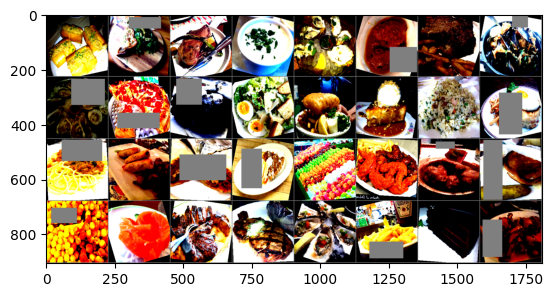

Bread   Egg  Meat  Soup Seafood  Meat  Meat Seafood Seafood Bread Dessert Vegetable-Fruit Fried food Dessert  Rice   Egg Noodles-Pasta Fried food Bread Dessert Vegetable-Fruit  Meat  Meat Bread Vegetable-Fruit Seafood  Meat  Meat Seafood Fried food Dessert  Meat


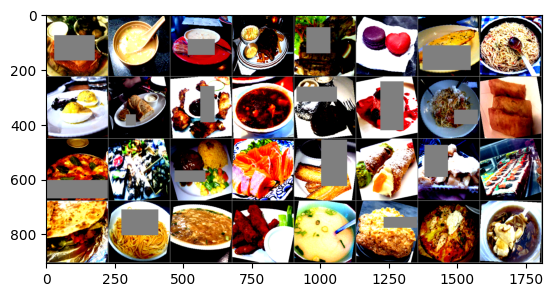

 Meat  Soup  Soup  Meat  Meat Dessert Bread Noodles-Pasta   Egg Bread  Meat  Soup  Meat Dessert Noodles-Pasta Fried food Bread Seafood  Meat Seafood Fried food Dessert Dessert Dessert Bread Noodles-Pasta  Soup  Meat  Soup Dessert Bread  Soup


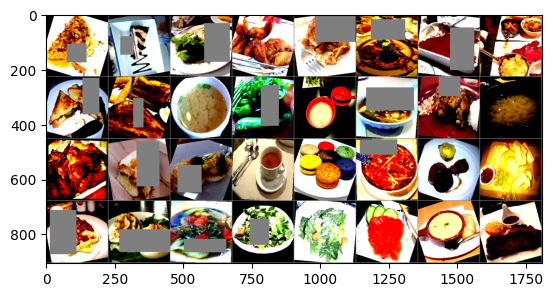

  Egg Dessert   Egg  Meat Dessert  Meat Dessert  Meat Bread Bread  Soup Vegetable-Fruit  Soup  Soup  Meat  Soup  Meat Bread   Egg  Soup Dessert  Soup  Meat Dairy product Dessert   Egg  Soup Vegetable-Fruit Vegetable-Fruit Seafood  Soup  Meat


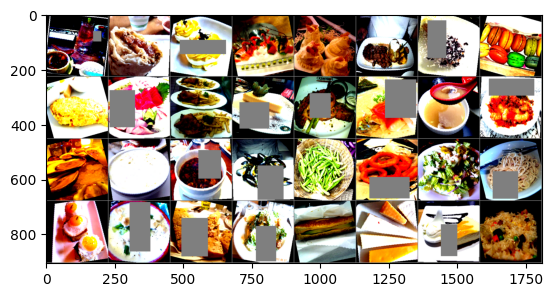

 Soup Bread   Egg Seafood   Egg  Meat Dessert Dessert   Egg Seafood Fried food Dessert  Meat Seafood  Soup Seafood Seafood  Soup  Soup Seafood Vegetable-Fruit Fried food Vegetable-Fruit Noodles-Pasta   Egg  Soup Bread Vegetable-Fruit Bread Dairy product Dessert  Rice


In [ ]:
images_set =[]
labels_set = []
# get some random training images
i=0
for images, labels in trainloader:
    # Your code to process each batch goes here
    # For example, you can print the shape of the batch
    images_set.append(images)
    labels_set.append(labels)
   # print("Batch shape:", image.shape)
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    i +=1
    if i == 5:
      break


In [ ]:
vgg16 = torchvision.models.vgg16()
# Modify the last layer for your specific classification task
num_classes = len(classes)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

In [ ]:
#model =vgg16
num_epochs = 10
# keep starting time and ending time
start_time = time.time()
model,history = fit(vgg16,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.3167, Train Accuracy:14.85%, Validation Loss: 2.2791, Validation Accuracy: 18.05%
Epoch 2/10, Training Loss: 2.2602, Train Accuracy:20.00%, Validation Loss: 2.2395, Validation Accuracy: 20.20%
Epoch 3/10, Training Loss: 2.2253, Train Accuracy:20.53%, Validation Loss: 2.2237, Validation Accuracy: 18.92%
Epoch 4/10, Training Loss: 2.1995, Train Accuracy:21.56%, Validation Loss: 2.1864, Validation Accuracy: 21.55%
Epoch 5/10, Training Loss: 2.1725, Train Accuracy:22.41%, Validation Loss: 2.1604, Validation Accuracy: 21.84%
Epoch 6/10, Training Loss: 2.1421, Train Accuracy:23.28%, Validation Loss: 2.1504, Validation Accuracy: 23.09%
Epoch 7/10, Training Loss: 2.1015, Train Accuracy:25.23%, Validation Loss: 2.1967, Validation Accuracy: 21.02%
Epoch 8/10, Training Loss: 2.0722, Train Accuracy:26.97%, Validation Loss: 2.0895, Validation Accuracy: 25.74%
Epoch 9/10, Training Loss: 2.0385, Train Accuracy:28.07%, Validation Loss: 2.0660, Validation Accuracy: 25.77%
E

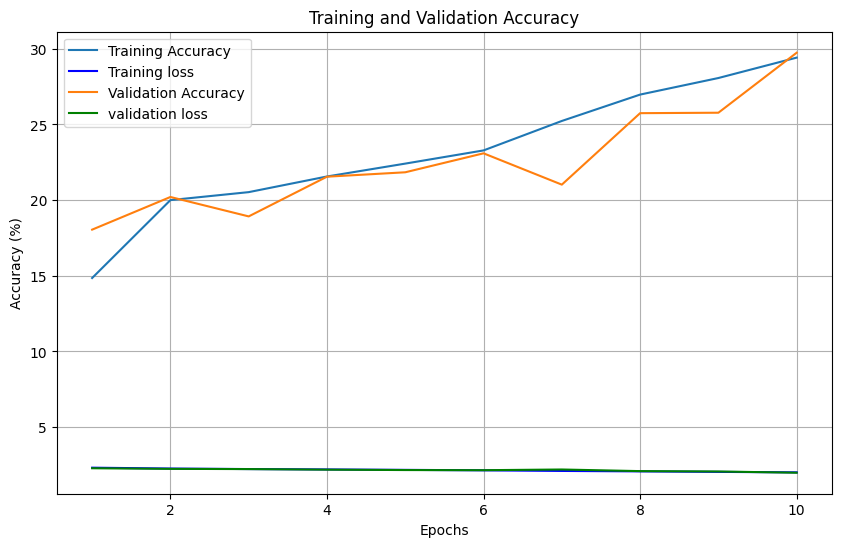

In [ ]:
plot_history(history,num_epochs)

In [ ]:
PATH = f'{path}/vgg16_32_224.pth'
torch.save(vgg16.state_dict(), PATH)
save_hist(history,f"{path}/vgg16_32_224.json")



In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])

base_line['vgg16_32_224'] = [val_acc,spend_time]




In [ ]:
# #export vgg16 model trained
# model_vgg = torchvision.models.vgg16(pretrained=True)
# model_vgg.classifier[6] = nn.Linear(4096, num_classes)
# model_vgg.to(device)
# PATH = f'{path}/vgg16.pth'
# model_vgg.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
# model_vgg.to(device)

In [ ]:
# history1 = export_hist(f"{path}/vgg16.json")
# plot_history(history1,num_epochs)

Rsenet

In [ ]:
# Define your ResNet model
resnet50 = torchvision.models.resnet50()
# Modify the output layer to match the number of classes in your dataset
num_classes = len(classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

The model builder above accepts the following values as the weights parameter. ResNet50_Weights.DEFAULT is equivalent to ResNet50_Weights.IMAGENET1K_V2. You can also use strings, e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Tue Oct 31 14:00:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
base_line = {'basic cnn': [26.53061224489796, 2475.005430459976],
 'vgg16': [55.27696793002915, 791.6775026321411],
 'resnet50': [27.871720116618075, 767.9913880825043],
 'vgg16_64': [22.39067055393586, 817.2729835510254],
 'resnet50_64': [32.6530612244898, 834.4013390541077],
 'vgg16_128_32': [19.620991253644316, 757.8417794704437],
 'resnet50_128_32': [22.332361516034986, 728.4337406158447],
 'vgg16_32_224': [29.737609329446062, 1840.2045896053314]}
base_line

{'basic cnn': [26.53061224489796, 2475.005430459976],
 'vgg16': [55.27696793002915, 791.6775026321411],
 'resnet50': [27.871720116618075, 767.9913880825043],
 'vgg16_64': [22.39067055393586, 817.2729835510254],
 'resnet50_64': [32.6530612244898, 834.4013390541077],
 'vgg16_128_32': [19.620991253644316, 757.8417794704437],
 'resnet50_128_32': [22.332361516034986, 728.4337406158447],
 'vgg16_32_224': [29.737609329446062, 1840.2045896053314]}

In [ ]:
# keep spending  time start time and end time
start_time = time.time()
num_epochs = 10
model,history = fit(resnet50,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 2.3936, Train Accuracy:16.11%, Validation Loss: 2.3791, Validation Accuracy: 15.48%
Epoch 2/10, Training Loss: 2.2983, Train Accuracy:17.77%, Validation Loss: 2.1818, Validation Accuracy: 22.24%
Epoch 3/10, Training Loss: 2.1519, Train Accuracy:22.03%, Validation Loss: 2.0723, Validation Accuracy: 24.61%
Epoch 4/10, Training Loss: 2.0279, Train Accuracy:27.05%, Validation Loss: 2.0005, Validation Accuracy: 28.34%
Epoch 5/10, Training Loss: 1.9594, Train Accuracy:29.96%, Validation Loss: 1.8985, Validation Accuracy: 32.77%
Epoch 6/10, Training Loss: 1.9115, Train Accuracy:32.57%, Validation Loss: 1.8417, Validation Accuracy: 36.38%
Epoch 7/10, Training Loss: 1.8680, Train Accuracy:34.13%, Validation Loss: 1.8744, Validation Accuracy: 32.77%
Epoch 8/10, Training Loss: 1.8251, Train Accuracy:35.99%, Validation Loss: 1.7596, Validation Accuracy: 37.90%
Epoch 9/10, Training Loss: 1.7888, Train Accuracy:37.12%, Validation Loss: 1.8242, Validation Accuracy: 36.27%
E

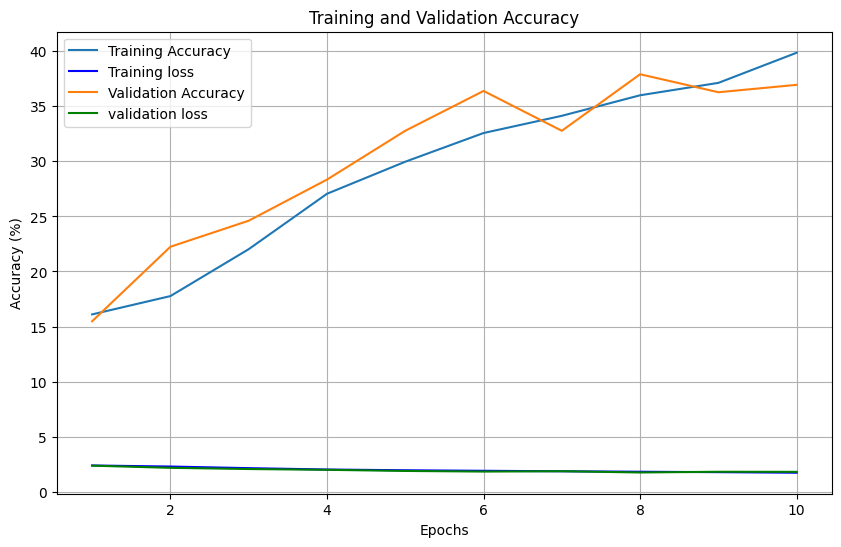

In [ ]:
plot_history(history,num_epochs)


In [ ]:
PATH = f'{path}/resnet50_32_224.pth'
torch.save(resnet50.state_dict(), PATH)
save_hist(history,f"{path}/resnet50_32_224.json")

In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])
base_line['resnet50_32_224']=[val_acc,spend_time]


add pretrain to VGG16 and resnet50

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
# Modify the last layer for your specific classification task
num_classes = len(classes)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.4MB/s]


In [ ]:
#model =vgg16
num_epochs = 10
# keep starting time and ending time
start_time = time.time()
model,history = fit(vgg16,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 1.3657, Train Accuracy:54.36%, Validation Loss: 0.9046, Validation Accuracy: 70.96%
Epoch 2/10, Training Loss: 0.6737, Train Accuracy:77.46%, Validation Loss: 0.6531, Validation Accuracy: 78.02%
Epoch 3/10, Training Loss: 0.5697, Train Accuracy:81.34%, Validation Loss: 0.5742, Validation Accuracy: 81.25%
Epoch 4/10, Training Loss: 0.5140, Train Accuracy:82.91%, Validation Loss: 0.6364, Validation Accuracy: 78.51%
Epoch 5/10, Training Loss: 0.4534, Train Accuracy:84.97%, Validation Loss: 0.5347, Validation Accuracy: 81.66%
Epoch 6/10, Training Loss: 0.4175, Train Accuracy:86.21%, Validation Loss: 0.5882, Validation Accuracy: 81.60%
Epoch 7/10, Training Loss: 0.3909, Train Accuracy:86.64%, Validation Loss: 0.4980, Validation Accuracy: 83.24%
Epoch 8/10, Training Loss: 0.3478, Train Accuracy:88.13%, Validation Loss: 0.5367, Validation Accuracy: 82.51%
Epoch 9/10, Training Loss: 0.3288, Train Accuracy:88.78%, Validation Loss: 0.4821, Validation Accuracy: 84.46%
E

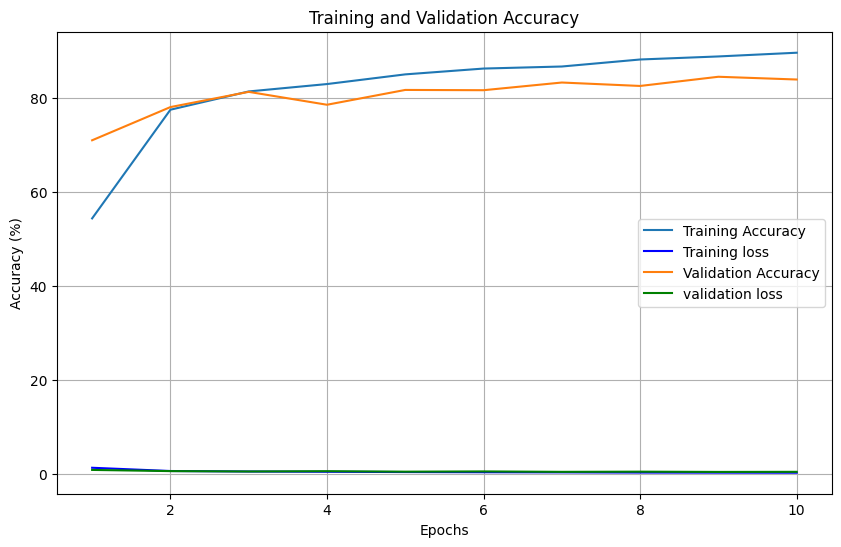

In [ ]:
plot_history(history,num_epochs)

In [ ]:
PATH = f'{path}/vgg16_32_224_pretrain.pth'
torch.save(vgg16.state_dict(), PATH)
save_hist(history,f"{path}/vgg16_32_224_pretrain.json")



In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])

base_line['vgg16_32_224_pretrain'] = [val_acc,spend_time]




In [ ]:
base_line
#test_acc_vgg,test_loss = evaluate(model,testloader)


{'basic cnn': [26.53061224489796, 2475.005430459976],
 'vgg16': [55.27696793002915, 791.6775026321411],
 'resnet50': [27.871720116618075, 767.9913880825043],
 'vgg16_64': [22.39067055393586, 817.2729835510254],
 'resnet50_64': [32.6530612244898, 834.4013390541077],
 'vgg16_128_32': [19.620991253644316, 757.8417794704437],
 'resnet50_128_32': [22.332361516034986, 728.4337406158447],
 'vgg16_32_224': [29.737609329446062, 1840.2045896053314],
 'resnet50_32_224': [37.90087463556851, 4098.392594337463],
 'vgg16_32_224_pretrain': [84.46064139941691, 1332.7040567398071]}

In [ ]:
# #export vgg16 model trained
# model_vgg = torchvision.models.vgg16(pretrained=True)
# model_vgg.classifier[6] = nn.Linear(4096, num_classes)
# model_vgg.to(device)
# PATH = f'{path}/vgg16.pth'
# model_vgg.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
# model_vgg.to(device)

In [ ]:
# history1 = export_hist(f"{path}/vgg16.json")
# plot_history(history1,num_epochs)

Rsenet

In [ ]:
# Define your ResNet model
resnet50 = torchvision.models.resnet50(pretrained=True)
# Modify the output layer to match the number of classes in your dataset
num_classes = len(classes)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
resnet50.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


The model builder above accepts the following values as the weights parameter. ResNet50_Weights.DEFAULT is equivalent to ResNet50_Weights.IMAGENET1K_V2. You can also use strings, e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [ ]:
# keep spending  time start time and end time
start_time = time.time()
num_epochs = 10
model,history = fit(resnet50,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
end_time = time.time()

Epoch 1/10, Training Loss: 1.0216, Train Accuracy:68.06%, Validation Loss: 0.5228, Validation Accuracy: 83.15%
Epoch 2/10, Training Loss: 0.6892, Train Accuracy:77.65%, Validation Loss: 0.6533, Validation Accuracy: 78.72%
Epoch 3/10, Training Loss: 0.4978, Train Accuracy:83.80%, Validation Loss: 0.5734, Validation Accuracy: 81.25%
Epoch 4/10, Training Loss: 0.4434, Train Accuracy:85.40%, Validation Loss: 0.6383, Validation Accuracy: 79.56%
Epoch 5/10, Training Loss: 0.3777, Train Accuracy:87.49%, Validation Loss: 0.5871, Validation Accuracy: 81.37%
Epoch 6/10, Training Loss: 0.3378, Train Accuracy:88.78%, Validation Loss: 0.4496, Validation Accuracy: 85.45%
Epoch 7/10, Training Loss: 0.2952, Train Accuracy:89.87%, Validation Loss: 0.4833, Validation Accuracy: 84.66%
Epoch 8/10, Training Loss: 0.2640, Train Accuracy:91.36%, Validation Loss: 0.4678, Validation Accuracy: 85.57%
Epoch 9/10, Training Loss: 0.2527, Train Accuracy:91.56%, Validation Loss: 0.5660, Validation Accuracy: 82.92%
E

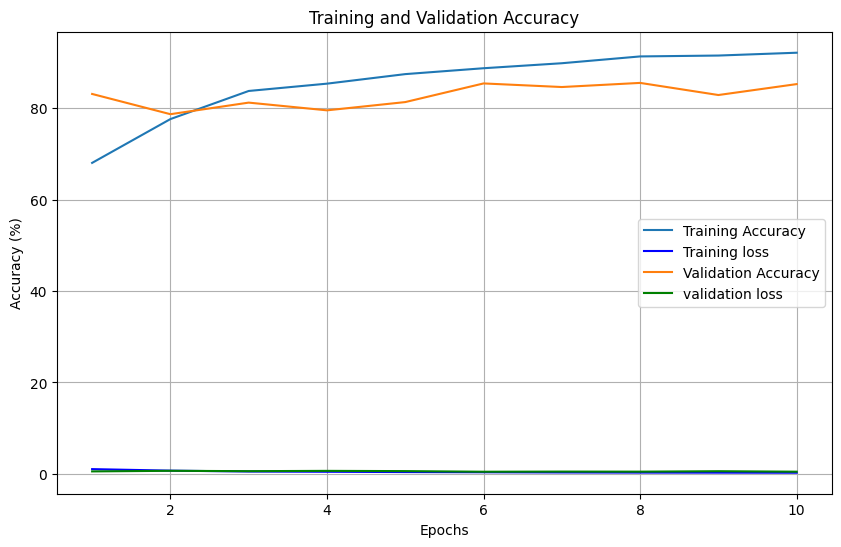

In [ ]:
plot_history(history,num_epochs)


In [ ]:
PATH = f'{path}/resnet50_32_224_pretrain.pth'
torch.save(resnet50.state_dict(), PATH)
save_hist(history,f"{path}/resnet50_32_224_pretrain.json")

In [ ]:
spend_time = end_time - start_time
val_acc = max(history['valid_acc'])
base_line['resnet50_32_224_pretrain']=[val_acc,spend_time]


In [ ]:
base_line

{'basic cnn': [26.53061224489796, 2475.005430459976],
 'vgg16': [19.737609329446062, 737.3647184371948],
 'resnet50': [27.871720116618075, 767.9913880825043],
 'vgg16_64': [22.39067055393586, 817.2729835510254],
 'resnet50_64': [32.6530612244898, 834.4013390541077],
 'vgg16_128_32': [19.620991253644316, 757.8417794704437],
 'resnet50_128_32': [22.332361516034986, 728.4337406158447],
 'vgg16_32_224': [29.737609329446062, 1840.2045896053314],
 'resnet50_32_224': [37.90087463556851, 4098.392594337463],
 'vgg16_32_224_pretrain': [84.46064139941691, 1332.7040567398071],
 'resnet50_32_224_pretrain': [85.56851311953353, 1357.7137651443481]}

In [ ]:
# Define hyperparameter search space
# test other learning rate
learning_rates = [0.01, 0.1]
batch_sizes = [32, 64, 128]
#dropout_rates = [0.0, 0.2, 0.5]
num_epochs = 10
best_accuracy = val_acc
best_model = model
best_history = history
best_result = {
    'model': model,
    'learning_rate': 0.001,
    'accuracy' : val_acc,
    'history' : history
}
model_para =[]
for learning_rate in learning_rates:
    print("learning rate : ", learning_rate)
  # Define a loss function, optimizer, and evaluation metric
    model = torchvision.models.resnet50(pretrained=True)
    # Modify the output layer to match the number of classes in your dataset
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Adjust learning rate and optimizer

    model,hist = fit(model,trainloader,valloader,optimizer,criterion,num_epochs,callback=[])
    PATH = f'{path}/cnn_resnet50_lr_{learning_rate}.pth'
    torch.save(model.state_dict(), PATH)
    save_hist(history,f"{path}/cnn_resnet50_lr_{learning_rate}.json")

    # return the maximum accuracy of the validation set
    acc = max(hist['valid_acc'])
    model_para.append({
      'model': model,
      'valacc':acc,
      'learningrate': learning_rate,
      'history':history
    })
    if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
            best_history = history
            best_result = {
                'model': model,
                'learning_rate': learning_rate,
                'accuracy' : best_accuracy,
                'history' : history

                }

print("Best Hyperparameters:")
print(best_result)
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
#print(model_para)

learning rate :  0.01


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Training Loss: 1.2736, Train Accuracy:60.86%, Validation Loss: 0.9789, Validation Accuracy: 70.41%
train loss is none,learning rate is too greate, change to smaller 
Training finished.
learning rate :  0.1
Epoch 1/10, Training Loss: 2.7509, Train Accuracy:15.50%, Validation Loss: 2.3038, Validation Accuracy: 14.87%
Epoch 2/10, Training Loss: 2.3018, Train Accuracy:14.88%, Validation Loss: 2.3012, Validation Accuracy: 14.58%
Epoch 3/10, Training Loss: 2.3006, Train Accuracy:14.94%, Validation Loss: 2.3072, Validation Accuracy: 13.09%
Epoch 4/10, Training Loss: 2.2978, Train Accuracy:15.32%, Validation Loss: 2.2881, Validation Accuracy: 14.58%
Epoch 5/10, Training Loss: 2.2823, Train Accuracy:16.68%, Validation Loss: 2.2608, Validation Accuracy: 16.71%
Epoch 6/10, Training Loss: 2.2717, Train Accuracy:16.93%, Validation Loss: 2.2585, Validation Accuracy: 15.95%
Epoch 7/10, Training Loss: 2.2659, Train Accuracy:17.25%, Validation Loss: 2.2544, Validation Accuracy: 16.59%
Epoch

In [ ]:
learning_rate = best_result['learning_rate']
print("Best learning rate: ", learning_rate)


Best learning rate:  0.001


In [ ]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
PATH = f'{path}/resnet50_32_224_pretrain.pth'
model.load_state_dict(torch.load(PATH))
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#evaluate best model on test set
learning_rate = best_result['learning_rate']
correct = 0
total = 0
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Adjust learning rate and optimizer
test_acc,test_loss = evaluate(model,testloader)


Accuracy of the network on the test images: 90 %
